In [258]:
%matplotlib inline
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib import collections
import numpy as np

from main import plot_segments, plot_lines
from cluster import cluster_segments
from optimize import find_vanishing_points
from itertools import permutations, combinations
from linesegmentintersections import bentley_ottman

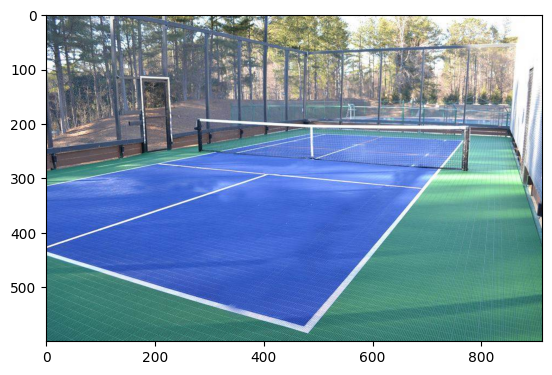

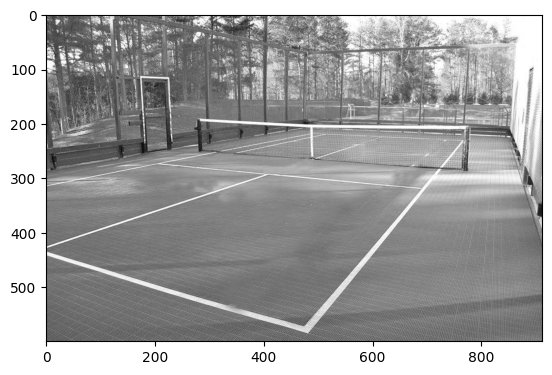

In [259]:
IM_PATH = "pb_court_1.jpg"
IM_PATH = "C:/Users/echapman/Downloads/pball_crawler/your_image_dir/000001.jpg"

im = cv.cvtColor(cv.imread(IM_PATH), cv.COLOR_BGR2RGB)
im_gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
plt.imshow(im)

plt.figure()
plt.imshow(im_gray, cmap="gray")

# plt.figure()
# im_gaus = cv.GaussianBlur(im, (31, 31), 0)
# im_blur = cv.medianBlur(im_gray, 51)
# im_mask = np.abs(im_gray - im_blur) < 200
# plt.imshow(im_mask, cmap="gray")
# plt.imshow(im_gaus)

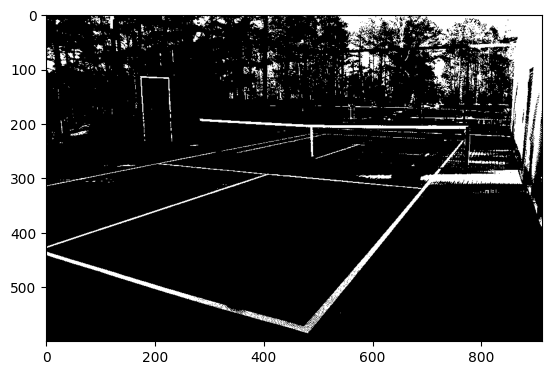

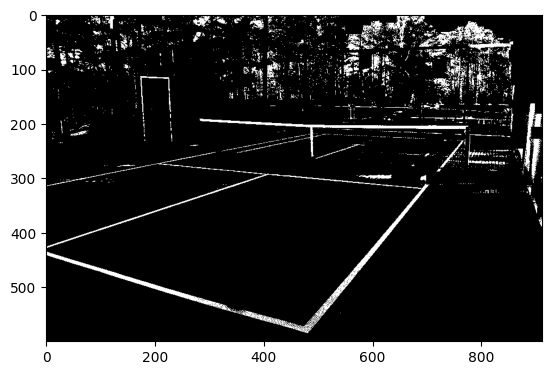

In [260]:
retval, im_thresh = cv.threshold(im_gray, 200, 255, cv.THRESH_BINARY)
plt.imshow(im_thresh, cmap="gray")
plt.figure()

area_threshold = 100

# def is_bad(con, im):
#     return False

#     convex_area = cv.contourArea(cv.convexHull(con))
#     area = cv.contourArea(con)

#     if area > 1 and area / convex_area > 0.25:
#         con_mask = cv.drawContours(np.zeros_like(im), [con], -1, 1, -1)
#         white_ratio = np.sum(np.multiply(im, con_mask)) / np.sum(con_mask) / 255
#         if white_ratio > 0.25:
#             return True
    
#     return False
#     # return area > 1000 and area / convex_area > 0.5

# contours, _ = cv.findContours(im_thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
# bad_contours = [con for con in contours if is_bad(con, im_thresh)]

im_thresh_trim = im_thresh - cv.dilate(
    cv.morphologyEx(im_thresh, cv.MORPH_OPEN, np.ones((11, 11))),
    np.ones((11, 11)))
im_thresh_trim = cv.dilate(im_thresh_trim, np.ones((1, 1)))
plt.imshow(im_thresh_trim, cmap="gray")

im_thresh = im_thresh_trim

(47, 4)


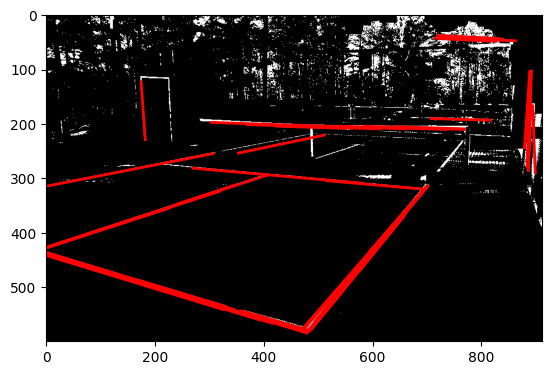

In [261]:
hough_lines = cv.HoughLinesP(
    image=im_thresh,
    rho=1,
    theta=np.pi / 180,
    threshold=75,
    minLineLength=100,
    maxLineGap=5,
)[:, 0, :]


_, ax1 = plt.subplots()
ax1.imshow(im_thresh, cmap="gray")
plot_segments(ax1, hough_lines, colors=["red"], linewidths=[2])
print(hough_lines.shape)

In [262]:
avg_lines = cluster_segments(hough_lines)["average_lines"]

# extend the lines by 10% per side to guarantee intersections
x1 = avg_lines[:, 0]
y1 = avg_lines[:, 1]
x2 = avg_lines[:, 2]
y2 = avg_lines[:, 3]
v12 = (avg_lines[:, 2:4] - avg_lines[:, 0:2])
extended_avg_lines = avg_lines.copy()
extended_avg_lines[:, 0:2] -= v12 * 0.1
extended_avg_lines[:, 2:4] += v12 * 0.1

36
52


<Figure size 640x480 with 0 Axes>

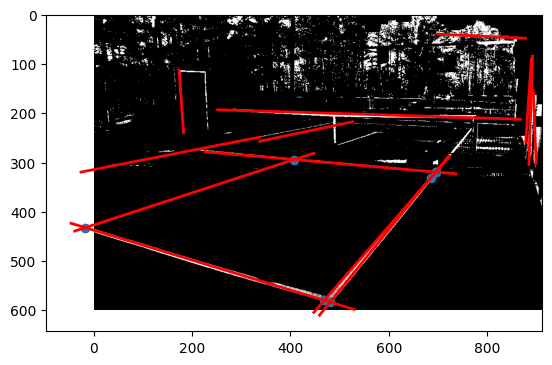

In [263]:
def get_intersection(l1: np.ndarray, l2: np.ndarray) -> np.ndarray | None:
    segments = np.asarray([[l1[:2], l1[2:]], [l2[:2], l2[2:]]]).tolist()
    intersections = bentley_ottman(segments)
    if len(intersections) > 0:
        return intersections[0].x, intersections[0].y
    else:
        return None

intersections = {}
for i, line_i in enumerate(extended_avg_lines):
    for j, line_j in enumerate(extended_avg_lines):
        if i < j:
            continue
        pt = get_intersection(line_i, line_j)
        if pt is not None:
            intersections[pt] = (i, j)

plt.figure()
_, ax2 = plt.subplots()
ax2.imshow(im_thresh, cmap="gray")
plot_segments(ax2, extended_avg_lines, colors=["red"], linewidths=[2])
inters = np.array([pt for pt in intersections])
plt.scatter(inters[:, 0], inters[:, 1])

# plt.figure()
# _, ax1 = plt.subplots()
# ax1.imshow(im_thresh, cmap="gray")
# plot_segments(ax1, extended_avg_lines, colors=["red"], linewidths=[1])
# for pt in intersections:
#     ax1.scatter(x=pt[0], y=pt[1])
#     ax1.text(x=pt[0], y=pt[1], s=str(intersections[pt]), fontweight="bold", color="yellow")
# from pprint import pprint; pprint(intersections)

graph = {pt: [] for pt in intersections}
for pt1, pt2 in combinations(intersections, r=2):
    if set(intersections[pt1]).intersection(set(intersections[pt2])):
        graph[pt1].append(pt2)
        graph[pt2].append(pt1)


# for pt, children in graph.items():
#     children = np.array(children).reshape((-1, 2))
#     plt.figure()
#     _, ax2 = plt.subplots()
#     ax2.imshow(im_thresh, cmap="gray")
#     plot_segments(ax2, extended_avg_lines, colors=["red"], linewidths=[1])

#     ax2.scatter(x=pt[0], y=pt[1])
#     ax2.text(x=pt[0], y=pt[1], s=str(intersections[pt]), fontweight="bold", color="yellow")
#     ax2.scatter(x=children[:, 0], y=children[:, 1])

# A corner is comprised of 3 nodes q r s where q shares an edge with r shares an edge with s
# but q and s do not share an edge.
corners = []
for q in graph:
    for r in graph[q]:
        for s in graph[r]:
            if (
                q != r and
                r != s and
                s != q and
                s not in graph[q]
            ):
                corners.append([q, r, s])
corners = np.array(corners)

double_corners = []
for q in graph:
    for r in graph[q]:
        for s in graph[r]:
            for t in graph[s]:
                if len([q, r, s, t]) == len(set([q, r, s, t])) and s not in graph[q] and t not in graph[r]:
                    double_corners.append([q, r, s, t])
double_corners = np.array(double_corners)

print(len(corners))
print(len(double_corners))

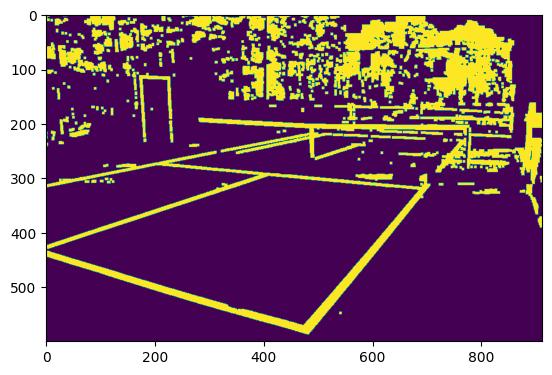

In [264]:
from court_graph import COURT_CORNERS, DENSE_COURT_POINTS, COURT_COORDS, DOUBLE_COURT_CORNERS
from focal_length import get_focal_length

#https://github.com/aliyasineser/GraduationProjectII/blob/master/RelativePositionTest.py
def inversePerspective(rvec, tvec):
    R, _ = cv.Rodrigues(rvec)
    R = np.matrix(R).T
    invTvec = np.dot(-R, np.matrix(tvec))
    invRvec, _ = cv.Rodrigues(R)
    return invRvec, invTvec


im_height, im_width, _ = im.shape

# my_im_corners = np.array([[[474, 583], [695, 320], [209, 276]]], dtype=float)
# my_court_corners = np.array([[[20, 0, 0], [20, 15, 0], [0, 15, 0]]]) * 0.3048

# my_im_corners = corners
# my_court_corners = COURT_CORNERS

im_target = cv.dilate(im_thresh_trim, np.ones((5, 5)))

rounds = []
for double_im_corner in double_corners:
    for double_court_corner in DOUBLE_COURT_CORNERS:
            ret, K, dist, rvec, tvec = cv.calibrateCamera(
                objectPoints=np.asarray([double_court_corner]).astype(np.float32),
                imagePoints=np.asarray([double_im_corner]).astype(np.float32),
                imageSize=im.shape[:2][::-1],
                cameraMatrix=None,
                distCoeffs=None,
                flags=cv.CALIB_FIX_PRINCIPAL_POINT + cv.CALIB_FIX_ASPECT_RATIO +
                    cv.CALIB_FIX_S1_S2_S3_S4 + cv.CALIB_FIX_K1 + cv.CALIB_FIX_K2 + cv.CALIB_FIX_K3 + cv.CALIB_FIX_K4 + cv.CALIB_FIX_K5 + cv.CALIB_FIX_K6 +
                    cv.CALIB_FIX_TAUX_TAUY + cv.CALIB_FIX_TANGENT_DIST,
            )

            rvec = rvec[0]
            tvec = tvec[0]

            # I'll put various conditions here to filter out nonphysical solutions
            if np.any(np.abs(tvec) > 100):
                continue

            pts_proj, _ = cv.projectPoints(
                objectPoints=DENSE_COURT_POINTS,
                rvec=rvec,
                tvec=tvec,
                cameraMatrix=K,
                distCoeffs=np.zeros((4, 1)),
            )
            pts_proj = np.array(pts_proj, dtype=int).squeeze()
            bool_mask = np.logical_and(
                np.logical_and(
                    pts_proj[:, 0] < im_width,
                    pts_proj[:, 1] < im_height),
                np.all(pts_proj > 0, axis=1),
            )
            pts_proj_safe = pts_proj[bool_mask]
            pts_proj_on_im = im_target.T[pts_proj_safe[:, 0], pts_proj_safe[:, 1]]
            score = np.sum(pts_proj_on_im > 0) - len(pts_proj) - np.sum(pts_proj_on_im == 0)

            if np.isclose(score, 0):
                print(pts_proj)
                print(pts_proj_safe)
                print(pts_proj_on_im)
                print(bool_mask)
                print(np.sum(pts_proj_on_im > 0), len(pts_proj), np.sum(pts_proj_on_im == 0))

            rounds.append((score, K, rvec, tvec, double_im_corner, double_court_corner))

plt.imshow(im_target)
plt.show()

4160
-1486
tvec
[[-5.32207662]
 [ 0.46159073]
 [ 5.30307972]]
rvec
[[ 1.7364569 ]
 [ 0.42194907]
 [-0.34612422]]
K
[[710.92757995   0.         455.5       ]
 [  0.         710.92757995 299.5       ]
 [  0.           0.           1.        ]]
[[-257  361]
 [-256  361]
 [-255  362]
 ...
 [ 752  206]
 [ 754  206]
 [ 756  206]]


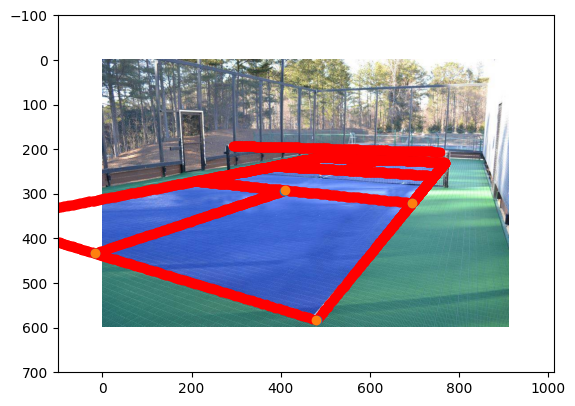

In [265]:
# from IPython.display import clear_output

rounds = sorted(rounds, key=lambda tup: tup[0], reverse=True)
print(len(rounds))

for i in range(len(rounds)):
    score, K, rvec, tvec, im_corner, court_corner = rounds[i]

    p1, p2, p3, p4 = im_corner
    if np.linalg.norm(p1 - p2) < 100 or np.linalg.norm(p2 - p3) < 100 or np.linalg.norm(p3 - p4) < 100:
        continue
    
    # wanted_court_corner = np.array([COURT_COORDS["d"], COURT_COORDS["f"], COURT_COORDS["c"]])
    # if not np.allclose(court_corner, wanted_court_corner):
    #     continue

    # if input(str(i)):
    #     break
    # clear_output()

    pts_proj = np.array(
        cv.projectPoints(
            objectPoints=DENSE_COURT_POINTS,
            rvec=rvec,
            tvec=tvec,
            cameraMatrix=K,
            distCoeffs=np.zeros((4, 1)),
        )[0],
        dtype=int
    ).squeeze()

    corner_proj = np.array(
        cv.projectPoints(
            objectPoints=court_corner,
            rvec=rvec,
            tvec=tvec,
            cameraMatrix=K,
            distCoeffs=np.zeros((4, 1)),
        )[0],
        dtype=int
    ).squeeze()

    print(score)
    print('tvec')
    print(tvec)
    print('rvec')
    print(rvec)
    print('K')
    print(K)

    print(pts_proj)

    _, ax = plt.subplots()
    ax.imshow(im)
    plt.scatter(x=pts_proj[:, 0], y=pts_proj[:, 1], color="red")
    plt.scatter(x=im_corner[:, 0], y=im_corner[:, 1])
    plt.scatter(x=corner_proj[:, 0], y=corner_proj[:, 1])
    ax.set_xlim((-100, im.shape[1] + 100))
    ax.set_ylim((100 + im.shape[0], -100))
    plt.show()

    break